In [1]:
import os
import urllib
import json
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fpdf import FPDF

In [2]:
def import_json_to_dict(url) :
    response = urllib.request.urlopen(url)
    my_dict = json.loads(response.read())
    return my_dict

In [3]:
def mkdir_ifnotexist(path) :
    if not os.path.isdir(path) :
        os.mkdir(path)

In [4]:
def format_amount(indic, valeur):
    if "Montant" in indic:
        f_valeur = float(valeur)
        if f_valeur > 1000000:
            return str(round(f_valeur/1000000, 1)) + ' M€'
        elif f_valeur > 10000:
            return str(round(f_valeur/1000, 1)) + ' k€'
        else:
            return str(f_valeur)
    else:
        return int(valeur.split(".")[0])

In [5]:
mailles = ["national", "regional", "departemental"]

In [6]:
pp_dep = pd.read_csv("pp_dep.csv", sep=";", dtype={"reg":str})

In [7]:
list_mesure_indic = list(pp_dep.pivot_table(index=["short_mesure", "short_indic"], values="valeur").index)

In [8]:
short_mesures_to_keep =set([
'AAP et AMI Efficacité énergétique',
'Assurance prospection',
"Ma Prime Rénov'",
"Prime à l'embauche des jeunes",
"Prime à l'embauche pour les travailleurs handicapés",
"Apprentissage",
"Bonus électrique",
"Contrats Initiatives Emploi (CIE) Jeunes",
'Contrats de professionnalisation',
'France Num : aide à la numérisation des TPE,PME,ETI',
'Garantie jeunes',
"AAP industrie : Modernisation des filières auto et aéro",
"Parcours emploi compétences (PEC) Jeunes",
'Prime à la conversion des véhicules légers',
"AAP Industrie : Soutien aux projets industriels territoires",
"AAP Industrie : Sécurisation approvisionnements critiques",
"Renforcement subventions Business France",
'Rénovation des bâtiments Etats (marchés notifiés)',
"Service civique",
'Soutien recherche aéronautique civil'
])
#print(list_mesure_indic)
#print(list(x[0] for x in list_mesure_indic if not(x[0] in short_mesures_to_keep)))
list_mesure_indic = [x for x in list_mesure_indic if x[0] in short_mesures_to_keep]

In [9]:
pp_reg = pd.pivot_table(pp_dep, index=["mesure","short_mesure", "reg","region", "Date", "period_date", "short_indic"], values="valeur", aggfunc=np.sum)
pp_reg.rename(columns={"reg":"libelle"}, inplace=True)
pp_reg.reset_index(inplace=True)

In [10]:
pp_nat = pd.pivot_table(pp_reg, index=["mesure", "short_mesure", "Date","period_date", "short_indic"], values="valeur", aggfunc=np.sum)
pp_nat.reset_index(inplace=True)

In [11]:
dict_mesure_indic = {}
for x in list_mesure_indic:
    if x[0] in dict_mesure_indic:
        dict_mesure_indic[x[0]].append(x[1])
    else:
        dict_mesure_indic[x[0]] = [x[1]]

In [12]:
dict_mesure_indic['AAP Industrie : Soutien aux projets industriels territoires'] = ['Nombre de TPE,PME,ETI bénéficiaires']
dict_mesure_indic['AAP Industrie : Sécurisation approvisionnements critiques'] = ['Nombre de TPE,PME,ETI bénéficiaires']
dict_mesure_indic['AAP et AMI Efficacité énergétique'] = ["Nombre d'entreprises ayant reçu l'aide"]
dict_mesure_indic['AAP industrie : Modernisation des filières auto et aéro'] = ['Nombre de PME']

In [13]:
# On ne veut pas afficher les lignes de Prime Rénov nulles
pp_dep = pp_dep.loc[(pp_dep.short_mesure != "Ma Prime Rénov'") | (pp_dep.valeur != 0) ]

In [14]:
pp_dep.valeur = pp_dep.valeur.astype(str)
pp_dep.valeur = pp_dep.apply(lambda x: format_amount(x["short_indic"], x["valeur"]), axis=1)

In [15]:
pp_reg.valeur = pp_reg.valeur.astype(str)
pp_reg.valeur = pp_reg.apply(lambda x: format_amount(x["short_indic"], x["valeur"]), axis=1)

In [16]:
pp_nat.valeur = pp_nat.valeur.astype(str)
pp_nat.valeur = pp_nat.apply(lambda x: format_amount(x["short_indic"], x["valeur"]), axis=1)

In [17]:
taxo_dep_url = 'https://raw.githubusercontent.com/etalab/dashboard-aides-entreprises/master/backend/json/taxonomies/departements-minify.json'
taxo_reg_url = 'https://raw.githubusercontent.com/etalab/dashboard-aides-entreprises/master/backend/json/taxonomies/regions-minify.json'

In [18]:
taxo_dep_df = pd.DataFrame(import_json_to_dict(taxo_dep_url))
dep_list = list(taxo_dep_df['dep'])
print('{} departements.'.format(len(dep_list)))

taxo_reg_df = pd.DataFrame(import_json_to_dict(taxo_reg_url))
reg_list = list(taxo_reg_df['reg'])
print('{} regions.'.format(len(reg_list)))

101 departements.
18 regions.


In [229]:
#Building the folders structures
pp_img_dir_path = './pp_img'
img_dir_path = './img/'
reports_dir_path = './reports/'

mkdir_ifnotexist(pp_img_dir_path)
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'national'))
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'national', 'France'))

#Regions subfolders
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'regional'))
for reg in reg_list :
    mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'regional', reg))
    
#Departements subfolders
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'departemental'))
for dep in dep_list :
    mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'departemental', dep))

mkdir_ifnotexist(reports_dir_path)

In [230]:
def make_pp_chart(maille, mesure, short_indics) :
    if maille == "departemental":
        df = pp_dep.loc[(pp_dep.short_mesure == mesure)].sort_values(by="period_date", ascending=True).copy()
        deps = pp_dep.dep.unique()
        
        default = df.groupby(["Date", "period_date"]).sum().sort_values("period_date", ascending=True).reset_index()
        default[short_indics] = '-'
        default = default[["Date"] + short_indics]

        for dep in deps:
            print(f"Plotting {mesure}-{short_indics} : departement {dep}")
            df_dep = df.loc[df.dep == dep]
            if df_dep.shape[0] == 0:
                ax = pp_plot(default)
            else:
                df_plot = pd.pivot_table(df_dep, index=['period_date', 'Date'], columns=['short_indic'], values='valeur', aggfunc='first')
                df_plot = df_plot.reset_index().drop('period_date', axis=1)
                df_plot = df_plot.rename_axis(None, axis=1)
                df_plot = df_plot.fillna('-')
                ax = pp_plot(df_plot)
            save_pp_plot(maille, dep, mesure, ax)  # short_indic est inutile dans le nom
            
    elif maille == "regional":
        df = pp_reg.loc[(pp_reg.short_mesure == mesure)].sort_values(by="period_date", ascending=True).copy()
        regs = df.reg.unique()
        
        default = df.groupby(["Date", "period_date"]).sum().sort_values("period_date", ascending=True).reset_index()
        default[short_indics] = '-'
        default = default[["Date"] + short_indics]

        for reg in regs:
            print(f"Plotting region {mesure}-{short_indics} : {reg}")
            df_reg = df.loc[df.reg == reg]
            if df_reg.shape[0] == 0:
                ax = pp_plot(default)
            else:
                df_plot = pd.pivot_table(df_reg, index=['period_date', 'Date'], columns=['short_indic'], values='valeur', aggfunc='first')
                df_plot = df_plot.reset_index().drop('period_date', axis=1)
                df_plot = df_plot.rename_axis(None, axis=1)
                df_plot = df_plot.fillna('-')
                ax = pp_plot(df_plot)
            save_pp_plot(maille, reg, mesure, ax)
            
    elif maille == "national":
        print(f"Plotting country {mesure}-{short_indics}")
        df_nat = pp_nat.loc[(pp_nat.short_mesure == mesure)].sort_values(by="period_date", ascending=True).copy()
        df_plot = pd.pivot_table(df_nat, index=['period_date', 'Date'], columns=['short_indic'], values='valeur', aggfunc='first')
        df_plot = df_plot.reset_index().drop('period_date', axis=1)
        df_plot = df_plot.rename_axis(None, axis=1)
        df_plot = df_plot.fillna('-')
        ax = pp_plot(df_plot)#, mesure, short_indic, "France")
        save_pp_plot(maille, "France", mesure, ax)

In [231]:
def format_col_labels(col_names_src, max_num_lines=3, num_char_threshold=14):
    """ Ajoute des retours à la ligne aux noms de colonnes pour réduire la largeur du texte 
    dans l'image. 
    :param str col_names_src: Liste des noms de colonnes.
    :param int max_num_lines: Nombre de lignes max. On n'ajoute plus de retour à la ligne par la suite.
    :param int num_char_threshold: Un retour à la ligne est ajouté dès lors que ce nombre de chars est atteint.
    """
    col_names = []
    for col_name_src in col_names_src:
        col_name = ''
        num_lines = 1
        num_chars_per_line = 0
        for word in col_name_src.split(' '):
            col_name += (word + ' ')
            num_chars_per_line += (len(word) + 1)
            if num_chars_per_line >= num_char_threshold and num_lines < max_num_lines:
                col_name += '\n'
                num_lines += 1
                num_chars_per_line = 0
        col_names.append(col_name.strip())
    return col_names


def pp_plot(data, col_width=7, row_height=1.4, font_size=20,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    # Réduire la largeur des colonnes
    col_names = format_col_labels(data.columns)
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=col_names, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])
    return ax

In [232]:
def save_pp_plot(maille, geo, mesure, ax):
    #print(maille, geo, mesure)
    path = os.path.join("pp_img", maille, geo)
    ax.figure.savefig(os.path.join(path, "{}.png".format(mesure)))
    plt.close()

In [233]:
def make_all_charts():
    for short_mesure in dict_mesure_indic:
        short_indics = dict_mesure_indic[short_mesure]
        for maille in mailles :
            make_pp_chart(maille, short_mesure, short_indics)

Plotting country AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires']
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 28
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 32
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 94
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 27
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 24
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 11
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 06
Plotting region AAP Industrie : Sout

KeyboardInterrupt: 

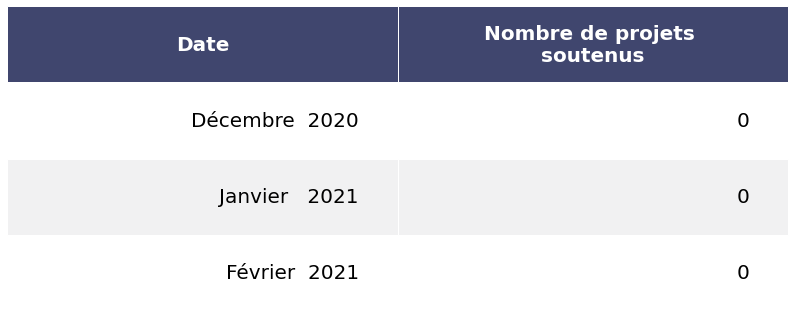

In [243]:
#%%time
make_all_charts()

In [49]:
col_width=6.0
row_height=0.625
font_size=14

In [50]:
global title_header
title_header = ''
global subtitle_header
subtitle_header = ''

In [51]:
class PDF(FPDF):
    def header(self):
        if (self.page_no() != 1 ):
            # Logo
            self.image(os.path.join(img_dir_path, 'LogoRF.png'), 10, 8, 33)
            self.image(os.path.join(img_dir_path, 'logo_Francerelance_1321294.54.png'), pdf.w-45, 7, 45)
            # Arial bold 15
            self.cell(40)
            self.add_font('Arial', 'B', 16, uni=True)
            self.set_font('Arial', 'B', 16)
            self.multi_cell(110, 10, title_header, 0, 1, 'A')

            # Move to the right
            # Title
            self.set_font('Arial', 'I', 9)
            self.cell(50)
            self.cell(50)
            #self.cell(50, 10, subtitle_header, 0, 1, 'A')#+' - aides-entreprises.data.gouv.fr', 0, 1, 'A', link='https://aides-entreprises.data.gouv.fr/')
            # Line break  
            pdf.line(40, 38, 170, 38)
            self.ln(7)
        
    # Page footer
    def footer(self):
        if (self.page_no() != 1 ):
            # Position at 1.5 cm from bottom
            self.set_y(-15)
            # Arial italic 8
            self.set_font('Arial', 'I', 8)
            # Page number
            
            #self.cell(0, 10, 'Direction Interministérielle du Numérique (DINUM) - Page ' + str(self.page_no()) + '/{nb}', 0, 0, 'C')         

In [79]:
def add_propilot_page_report(pdf, dep, short_mesure, phrase_nombre, source_dict):
    
    pdf.set_fill_color(83,101,125);

    pdf.set_y(47.00125)
    
    
    # Print KPI
    short_indic = dict_mesure_indic[short_mesure][0]
    kpi_dep = (pp_dep.loc[(pp_dep.dep == dep) 
                          & (pp_dep.short_mesure == short_mesure) 
                          & (pp_dep.short_indic == short_indic)]
                .sort_values(by="period_date", ascending=False))
    if kpi_dep.shape[0] != 0:
        date= kpi_dep.iloc[0].Date
        valeur = kpi_dep.iloc[0].valeur
    else:
        date = pp_dep.Date.max()
        valeur = 0
    
    pdf.add_font('Arial', '', 'arial.ttf', uni=True)
    pdf.set_font('Arial', '', 12)
    pdf.cell(12, 10, f"À {date}, {short_indic} : {valeur} (données cumulées)")
    pdf.ln(10)
 
    pdf.set_text_color(0,0,0)

    # Niveau National
    pdf.set_font('Arial', 'BI', 14)
    pdf.cell(65, 10, "Niveau National", ln=1)
    
    pdf.set_font('Arial', '', 14)

    hbar_w = 120
    pdf.set_y(77)  # Ligne temporaire pour éviter que des tableaux dépassent sur le texte "Niveau Régional"
    pdf.image(os.path.join(pp_img_dir_path, 'national','France', f"{short_mesure}.png"), 
              x=0, y=74, w=hbar_w)

    pdf.ln(12)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(10)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(27)

    reg = taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['reg']
    libelle_reg = taxo_reg_df[taxo_reg_df['reg'] == reg].iloc[0]['libelle']
    libelle_dep = taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['libelle']
    
    
    # Niveau Régional
    pdf.set_font('Arial', 'BI', 14)
    pdf.cell(65, 10, "Niveau Régional : "+libelle_reg, ln=1)

    pdf.set_font('Arial', '', 14)

    path_reg = os.path.join(pp_img_dir_path, 'regional',reg, f"{short_mesure}.png")
    if os.path.exists(path_reg):    
        pdf.image(path_reg, x=0, y=133, w=hbar_w)
    pdf.ln(10)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(15)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(10)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(25)

    # Niveau Départemental
    pdf.set_font('Arial', 'BI', 14)
    pdf.cell(65, 15, "Niveau Départemental : "+libelle_dep, ln=1) 

    pdf.set_font('Arial', '', 14)
    path_dep = os.path.join(pp_img_dir_path, 'departemental', dep, f"{short_mesure}.png")
    if os.path.exists(path_dep):
        pdf.image(path_dep, x=0, y=210, w=hbar_w)
        
    pdf.ln(8)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(15)
    pdf.cell((pdf.w/3)*1.55)
    
    return pdf

In [80]:
#%%time

mkdir_ifnotexist(os.path.join(reports_dir_path))

counter = 0
for dep in taxo_dep_df.dep.unique():
    counter += 1
    
    pdf = PDF()
    pdf.alias_nb_pages()
    pdf.add_page()

    #Logos
    pdf.image(os.path.join(img_dir_path, 'LogoRF.png'), 10, 8, 33)
    pdf.image(os.path.join(img_dir_path, 'logo_Francerelance_1321294.54.png'), pdf.w-45, 7, 45)
    
    # Arial bold 15
    pdf.set_font('Arial', 'B', 28)
    # Move to the right
    pdf.cell(50)
    pdf.ln(70)
    
    # Title
    pdf.cell(10)
    pdf.cell(50, 10, 'SUIVI TERRITORIAL', 0, 1, 'A')
    pdf.ln(10)
    pdf.cell(10)
    pdf.cell(50, 10, 'DU PLAN DE RELANCE', 0, 1, 'A')
    pdf.ln(10)
    pdf.cell(10)
    pdf.cell(50)

    pdf.set_font('Arial', 'I', 20)
    pdf.ln(10)
    pdf.cell(10)
    pdf.cell(50, 10, 'Données pour le département : '+taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['libelle'], 0, 1, 'A')
    pdf.ln(110)

    pdf.set_font('Arial', 'I', 8)

    pdf.cell(10)
       
    # TEST PROPILOT
    for short_mesure in short_mesures_to_keep:
        source_dict= {'name':'Les données utilisées proviennent de ProPilot', 
                      'url':'https://dares.travail-emploi.gouv.fr/dares-etudes-et-statistiques/tableaux-de-bord/le-marche-du-travail-pendant-le-covid-19/tableaux-de-bord-hebdomadaires'}

        title_header = short_mesure
        
        pdf.add_page()
        pdf = add_propilot_page_report(pdf, dep, short_mesure,' : ', source_dict) 
    departement = taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['libelle']
    pdf.output(os.path.join(reports_dir_path, 'Suivi_territorial_plan_relance_'+ departement+'.pdf'), 'F')
    
    print(str(datetime.datetime.today()) + ' - ' + dep + ' done.')

2021-03-17 17:59:18.951776 - 01 done.
2021-03-17 17:59:36.970231 - 02 done.
2021-03-17 17:59:54.966985 - 03 done.


KeyboardInterrupt: 

In [235]:
from reportlab.pdfgen import canvas
from reportlab.platypus import (SimpleDocTemplate, Paragraph, PageBreak, Image, Spacer, Table, TableStyle, KeepInFrame, Frame)
from reportlab.lib.enums import TA_LEFT, TA_RIGHT, TA_CENTER, TA_JUSTIFY
from reportlab.lib.styles import ParagraphStyle, getSampleStyleSheet
from reportlab.lib.pagesizes import LETTER, inch
from reportlab.graphics.shapes import Line, LineShape, Drawing
from reportlab.lib.colors import Color
from reportlab.pdfbase.acroform import AcroForm
from reportlab.lib import colors
from reportlab.platypus.flowables import Flowable
import PIL

In [250]:
def get_image_size(image_path):
    image = PIL.Image.open(image_path)
    width, height = image.size
    return width, height


def get_kpi(dep, short_indic, short_mesure):
    kpi_dep = (pp_dep.loc[(pp_dep.dep == dep) 
                          & (pp_dep.short_mesure == short_mesure) 
                          & (pp_dep.short_indic == short_indic)]
                .sort_values(by="period_date", ascending=False))
    if kpi_dep.shape[0] != 0:
        date= kpi_dep.iloc[0].Date
        valeur = kpi_dep.iloc[0].valeur
    else:
        date = pp_dep.Date.max()
        valeur = 0
    return date, valeur


class ReportCanvas(canvas.Canvas):

    def __init__(self, *args, **kwargs):
        canvas.Canvas.__init__(self, *args, **kwargs)
        self.pages = []
        self.width, self.height = LETTER
        self.flag = False

    def showPage(self):
        self.pages.append(dict(self.__dict__))
        self._startPage()

    def save(self):
        page_count = len(self.pages)
        for page in self.pages:
            self.__dict__.update(page)
            self.draw_canvas(page_count, self._pageNumber)
            canvas.Canvas.showPage(self)
        canvas.Canvas.save(self)

    def draw_canvas(self, page_count, page_number):
        page = f"Page {self._pageNumber} sur {page_count}"
        x = 128
        self.saveState()
        self.setStrokeColorRGB(0, 0, 0)
        self.setLineWidth(0.5)
        self.drawImage("img/LogoRF.png", self.width - inch * 8 - 5, self.height - 120, width=100, height=100,
                       preserveAspectRatio=True)
        self.drawImage("img/logo_Francerelance_1321294.54.png", self.width - inch * 2, self.height - 130, width=130, height=130,
                       preserveAspectRatio=True)
        if page_number > 1:
            self.line(130, 680, LETTER[0] - 130, 680)  # Séparateur haut-de-page
            self.line(66, 78, LETTER[0] - 66, 78)  # Séparateur pied-de-page
            self.setFont('Times-Roman', 10)
            self.drawString(LETTER[0] - x, 65, page)
        self.restoreState()
        
        
class InteractiveTextfield(Flowable):
    def __init__(self, x, y, width, height, text='textfield'):
        Flowable.__init__(self)
        self.text = text
        self.x = x
        self.y = y
        self.width = width
        self.height = height

    def draw(self):
        self.canv.saveState()
        form = self.canv.acroForm
        form.textfield(name=self.text, relative=True, 
                       x=self.x, y=self.y, width=self.width, height=self.height,
                      maxlen=255, value='Entrez un commentaire...', fillColor=colors.white, )
        self.canv.restoreState()
        return

    
class PDFReport:
    
    def __init__(self, path, code_dep):
        self.path = path
        self.styleSheet = getSampleStyleSheet()
        self.elements = []  # Story
        self.dep = code_dep
        self.dep_name = taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['libelle']
        self.font = 'Arial'
        self.page_count = 0  # Increment 

    
    def create_front_page(self):
        # All texts
        text_title = "<b>SUIVI TERRITORIAL <br/> DU PLAN DE RELANCE</b>"
        text_subtitle = f"<i>Données pour le département : {self.dep_name}</i>"
        text_date = f"<i>Date : {datetime.datetime.today().strftime('%Y-%m-%d')}</i>"
        
        self.elements.append(Spacer(30, 150))  # Décale le titre vers le bas
        
        # Titre du rapport
        title_style = ParagraphStyle(self.font, fontSize=30, leading=60, justifyBreaks=1, alignment=TA_LEFT, justifyLastLine=1)
        title = Paragraph(text_title, title_style)
        self.elements.append(title)
        
        self.elements.append(Spacer(0, 30))
        
        # Sous-titre avec le nom du département
        subtitle_style = ParagraphStyle(self.font, fontSize=20, leading=50, justifyBreaks=1, alignment=TA_LEFT, justifyLastLine=1)
        subtitle = Paragraph(text_subtitle, subtitle_style)
        self.elements.append(subtitle)
        
        # Date de création du rapport
        date_style = ParagraphStyle(self.font, fontSize=20, leading=50, justifyBreaks=1, alignment=TA_LEFT, justifyLastLine=1)
        date = Paragraph(text_date, date_style)
        self.elements.append(date)
        
        self.elements.append(PageBreak())
        self.page_count += 1
    
    
    def create_content_page(self, short_mesure):
        reg = taxo_dep_df[taxo_dep_df['dep'] == self.dep].iloc[0]['reg']
        reg_name = taxo_reg_df[taxo_reg_df['reg'] == reg].iloc[0]['libelle']
        
        # Affichage mesure
        text_mesure = f"<b>{short_mesure}</b>"
        mesure_style = ParagraphStyle(self.font, fontSize=15, leading=15, justifyBreaks=1, alignment=TA_CENTER, justifyLastLine=1)
        mesure = Paragraph(text_mesure, mesure_style)
        block_mesure = KeepInFrame(288, 576, [mesure], hAlign='CENTER')  # Pour créer des retours à la ligne en cas de textes longs
        self.elements.append(block_mesure)
        self.elements.append(Spacer(1, 60))
        
        # Affichage phrase indic
        short_indic = dict_mesure_indic[short_mesure][0]
        date, valeur = get_kpi(self.dep, short_indic, short_mesure)
        text_indic = f"En {date}, {short_indic} : {valeur} (données cumulées)"
        indic_style = ParagraphStyle(self.font, fontSize=11, leading=20, justifyBreaks=1, alignment=TA_LEFT, justifyLastLine=1)
        sentence_indic = Paragraph(text_indic, indic_style)
        self.elements.append(sentence_indic)
        
        # Affichage par niveau de localité --> Table
        text_national = f"Niveau National"
        img_path_national = f'pp_img/national/France/{short_mesure}.png'
        title_national, img_national = self._get_block_indic_for_locality(text_national, img_path_national)
        
        text_regional = f"Niveau Régional : {reg_name}"
        img_path_regional = f'pp_img/regional/{reg}/{short_mesure}.png'
        title_regional, img_regional = self._get_block_indic_for_locality(text_regional, img_path_regional)
        
        text_departemental = f"Niveau Départemental : {self.dep_name}"
        img_path_departemental = f'pp_img/departemental/{dep}/{short_mesure}.png'
        title_departemental, img_departemental = self._get_block_indic_for_locality(text_departemental, img_path_departemental)
    
        data_table = [  [text_national,], # First row or headers
                        [img_national, ], # Second row
                        [text_regional, ], # Third row
                        [img_regional, ],
                        [text_departemental, ],
                        [img_departemental,],] # Fourth row

        img_cell_height = 130
        title_cell_height = 20
        row_table_heights = [title_cell_height, img_cell_height, 
                             title_cell_height, img_cell_height, 
                             title_cell_height, img_cell_height, 
                            ]
        style = TableStyle(
            [
                ('FONTNAME', (0,0), (0,-1), 'Helvetica-Bold'),
                ('ALIGN', (0,0), (0,-1), 'CENTER'),
                ('VALIGN',(0,0),(0,-1),'TOP'),
            ]
        )
        table = Table(data_table, colWidths=10, rowHeights=row_table_heights, hAlign='CENTER', style=style)
        self.elements.append(table)
        
        form_textfield = InteractiveTextfield(x=0, y=-10, width=LETTER[0]-132, height=50, name=f"textfield{self.page_count}")
        self.elements.append(form_textfield)

        self.elements.append(PageBreak())
        self.page_count += 1
        
    def _get_block_indic_for_locality(self, text_title, img_table_path):
        # Affichage titre
        title = Paragraph(text_title)

        # Affichage image
        # Adapter width par rapport à la taille original de l'image et le nombre de colonne
        SRC_WIDTH_PER_COL = 504
        WIDTH_PER_COL = 150  # On se fixe une largeur de colonne commune à toutes les images
        src_width, src_height = get_image_size(img_table_path)
        num_col = src_width // SRC_WIDTH_PER_COL
        width = WIDTH_PER_COL * num_col
        
        img = Image(img_table_path,  hAlign="LEFT", width=width, height=140, kind='proportional')
        return title, img
    
    
    def save_report(self):
        self.doc = SimpleDocTemplate(self.path, pagesize=LETTER, topMargin=50)
        self.doc.multiBuild(self.elements, canvasmaker=ReportCanvas)

        

def create_single_report(dep, report_path):
    """ Créer un document PDF concernant le departement indiqué.
    :param dep code département (ex: 01, 72...)
    :param report_path
    """
    report = PDFReport(report_path, dep)
    
    report.create_front_page()

    for short_mesure in short_mesures_to_keep:
        report.create_content_page(short_mesure)

    report.save_report()


dep = '94'
report_path = 'test_report.pdf'
create_single_report(dep, report_path)

TypeError: __init__() got an unexpected keyword argument 'name'

In [241]:
%%time
mkdir_ifnotexist(os.path.join(reports_dir_path))

counter = 0
for dep in taxo_dep_df.dep.unique():
    departement = taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['libelle']
    report_path = os.path.join(reports_dir_path, 'Suivi_territorial_plan_relance_'+ departement+'.pdf')
    create_single_report(dep, report_path)
    
    print(str(datetime.datetime.today()) + ' - ' + dep + ' done.')

2021-03-19 15:55:33.098158 - 01 done.
2021-03-19 15:55:34.635613 - 02 done.
2021-03-19 15:55:36.183892 - 03 done.
2021-03-19 15:55:37.738158 - 04 done.
2021-03-19 15:55:39.306136 - 05 done.
2021-03-19 15:55:40.881747 - 06 done.
2021-03-19 15:55:42.496320 - 07 done.
2021-03-19 15:55:44.062026 - 08 done.
2021-03-19 15:55:45.614027 - 09 done.
2021-03-19 15:55:47.182656 - 10 done.
2021-03-19 15:55:48.750748 - 11 done.
2021-03-19 15:55:50.302913 - 12 done.
2021-03-19 15:55:51.870236 - 13 done.
2021-03-19 15:55:53.421363 - 14 done.
2021-03-19 15:55:55.021621 - 15 done.
2021-03-19 15:55:56.603302 - 16 done.
2021-03-19 15:55:58.183282 - 17 done.
2021-03-19 15:55:59.763009 - 18 done.
2021-03-19 15:56:01.342623 - 19 done.
2021-03-19 15:56:02.924895 - 21 done.
2021-03-19 15:56:04.477849 - 22 done.
2021-03-19 15:56:06.041793 - 23 done.
2021-03-19 15:56:07.631976 - 24 done.
2021-03-19 15:56:09.226506 - 25 done.
2021-03-19 15:56:10.816940 - 26 done.
2021-03-19 15:56:12.398880 - 27 done.
2021-03-19 1

FileNotFoundError: [Errno 2] No such file or directory: 'pp_img/departemental/95/Soutien recherche aéronautique civil.png'